# Twitter Hatespeech Detection Using NLP
#**NOTEBOOK BY:**

# PS/MCS/21/0007
# PS/MCS/21/0009


---



---



---



---




#Task
Detecting hate speech in tweets based on a labeled data

# Dataset

For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

Content
Full tweet texts are provided with their labels for training data.
Mentioned users' username is replaced with @user.

#Importing Libraries

In [51]:
# import the required libraries

import nltk
nltk.download('stopwords')
nltk.download('punkt') #Punkt Sentence Tokenizer. This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install numpy
!pip install pandas

from google.colab import drive
drive.mount('/content/drive')

###################################
import pandas as pd
import numpy as np
import re #regular expression 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')


from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#using grid search CV
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC

from PIL import Image


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
#https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?select=train.csv

train_path = "/content/drive/MyDrive/Colab Notebooks/Twitter_hateSpeech_NLP/train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/Twitter_hateSpeech_NLP/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [53]:
#Getting basic info about the training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


######our train data has no Null values

In [54]:
train_df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [55]:
test_df

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."


In [56]:
#Getting basic info about the TESTING dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


In [57]:
# printing random tweets 
# print(train_df['tweet'].iloc[4:50],"\n")
print(train_df['tweet'].iloc[0],"\n")
print(train_df['tweet'].iloc[1],"\n")
print(train_df['tweet'].iloc[2],"\n")
print(train_df['tweet'].iloc[3],"\n")
print(train_df['tweet'].iloc[4],"\n")

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run 

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked 

  bihday your majesty 

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦   

 factsguide: society now    #motivation 



# DATA PROCESSING

Preprocessing Function

- We removed callouts or usernames, which is preceded by @
- We removed character references, which includes HTML character references, but also emojis, unicode characters
- We removed the hash from the hashtags and decided to keep some of them because the hashtags are words or word-like and were used to connect represent similar content across users
- We removed the Twitter codes RT and QT for retweet and quotetweet
- We removed the HTML links since a lot of users linking a website reference as part of the tweet
- We then removed any punctuation
- We then lowercased all the tweets
- We removed any numbers and number containing words
- We removed any extra whitespace and any leading and trailing whitespace


In [58]:
#creating a function to process the data
def data_processing(tweet):
    #lower casing 
    tweet = tweet.lower()
    #remove callout and usernames
    tweet = re.sub(r'@[\S]+','', tweet)
    #remove character refernce eg &amp;
    tweet = re.sub(r"&[\S]+?;", '', tweet)
    #remove URL and Hastags 
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE) 
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'(#\w*,)|(#\w*$)|(#[\S]+)','', tweet)
    #removing RT and QT
    tweet = re.sub(r'(\bRT\b|\bQT\b)', '', tweet)
    #remove numbers or words with digits  
    tweet = re.sub(r'\w*\d\w*', r'', tweet)
    #remove puntuations
    tweet = re.sub(r'[^\w\s]','',tweet) 
    #removing ð, Ã character
    tweet = re.sub(r'ð','',tweet)
    tweet = re.sub(r'ø|ù|ø¹|â','',tweet)
    #remove any double or more whitespaces to single whitespaces
    tweet = re.sub(r'\s\s+', ' ', tweet)
    #remove any leading and trailing whitespace
    tweet = re.sub(r'(\A\s+|\s+\Z)', '', tweet)
    # Tokenize and remove stopwords
    tweet_tokens = word_tokenize(tweet) 
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [59]:
#passing the Both dataset to the data preprocessing function
train_df.tweet = train_df['tweet'].apply(data_processing)
test_df.tweet = test_df['tweet'].apply(data_processing)

In [60]:
#remove Both duplicates
train_df = train_df.drop_duplicates('tweet')
test_df = test_df.drop_duplicates('tweet')

### Lemmetization

In [61]:
#define a Lemmetization function
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data]
    return data

In [62]:
#Pass the Both dataset to the lemmetization function
train_df['tweet'] = train_df['tweet'].apply(lambda x: lemmatizing(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x_test_data: lemmatizing(x_test_data))

In [63]:
# printing the train data to see the effect of data preprocessing on training dataset
print(train_df['tweet'].iloc[0],"\n")
print(train_df['tweet'].iloc[1],"\n")
print(train_df['tweet'].iloc[2],"\n")
print(train_df['tweet'].iloc[3],"\n")
print(train_df['tweet'].iloc[4],"\n")

father dysfunctional selfish drags kids dysfunction run 

thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked 

bihday majesty 

model love u take u time ur 

factsguide society motivation 



In [64]:
#checking the info after Preprocessing the train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28281 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      28281 non-null  int64 
 1   label   28281 non-null  int64 
 2   tweet   28281 non-null  object
dtypes: int64(2), object(1)
memory usage: 883.8+ KB


*Now we can see that the entries has dropped from 31962 to 28281*

# EDA / Data visualization 

In [65]:
#count number of hatespeech against non Hatespeech
train_df['label'].value_counts()

0    26451
1     1830
Name: label, dtype: int64

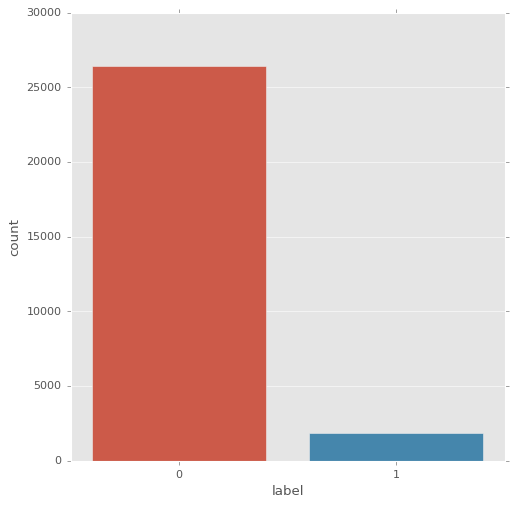

In [66]:
#countplot for Hatespeech and NonHatespeech
fig = plt.figure(figsize=(7,7))
sns.countplot(x='label', data = train_df)

Text(0.5, 1.0, 'Distribution of sentiments')

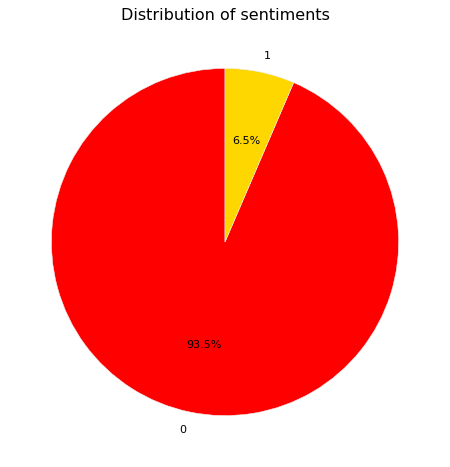

In [67]:
#pie plot of the distribution of Hate and non Hate speech
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
tags = train_df['label'].value_counts()
tags.plot(kind='pie',autopct = '%1.1f%%',  colors = colors, startangle =90, label='')
plt.title('Distribution of sentiments')

In [68]:
#extracting Non HateSpeech
non_hate_tweets = train_df[train_df.label == 0]
non_hate_tweets.head()

,id,label,tweet
0,1,0,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday majesty
3,4,0,model love u take u time ur
4,5,0,factsguide society motivation


In [69]:
#extracting HateSpeech tweets
neg_tweets = train_df[train_df.label == 1]
neg_tweets.head()

,id,label,tweet
13,14,1,cnn calls michigan middle school build wall ch...
14,15,1,comment australia opkillingbay seashepherd hel...
17,18,1,retweet agree
23,24,1,lumpy says prove lumpy
34,35,1,unbelievable century wed need something like n...


### using Word cloud

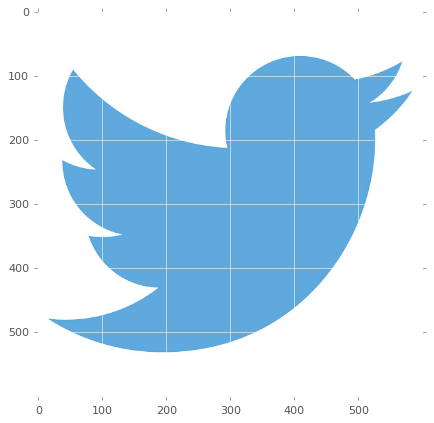

In [70]:
plt.imshow(np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Twitter_hateSpeech_NLP/twitter.jpeg")))

In [71]:
#Function to plot Word Cloud
def word_cloud(tweet_data, title):
  mask = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/Twitter_hateSpeech_NLP/twitter.jpeg"))
  text = ' '.join([word for word in tweet_data['tweet']])
  plt.figure(figsize=(15,10), facecolor='None')
  #wordcloud = WordCloud(max_words=500, width=1600, height=800, mask=mask).generate(text)
  wordcloud = WordCloud(
      background_color='white', 
      width=2600, height=800, 
      max_words=500, 
      mask=mask, 
      contour_color = 'gray', contour_width = 1
      ).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(title, fontsize = 19)
  plt.show()


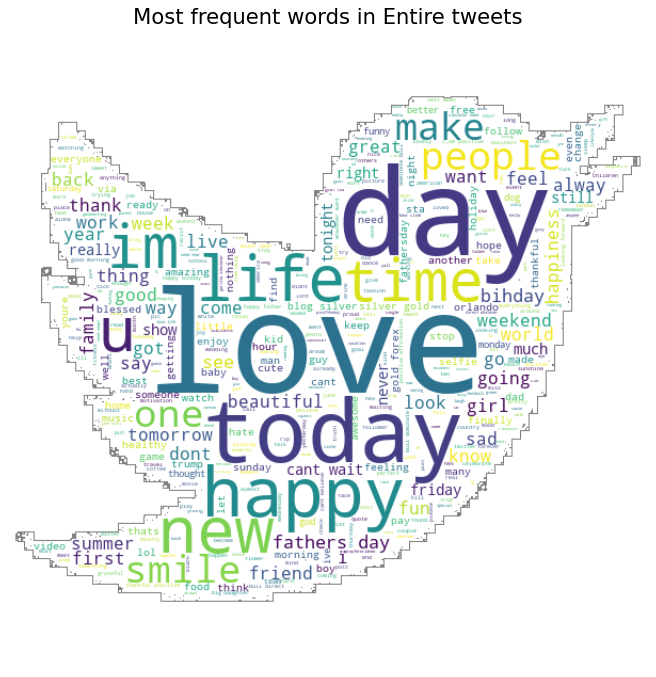

In [72]:
# Most frequents words in the entire dataset
word_cloud(train_df, 'Most frequent words in Entire tweets')

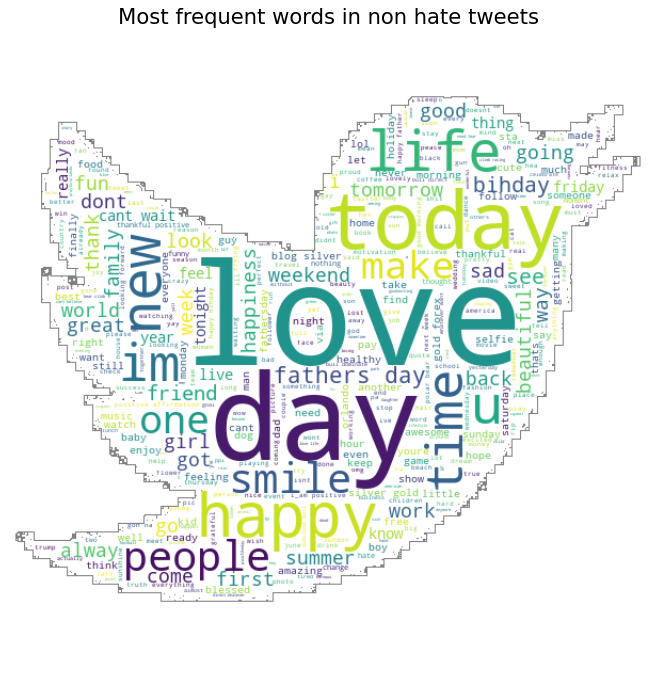

In [73]:
#plot of word cloud for the Non HateSpeech
word_cloud(non_hate_tweets, 'Most frequent words in non hate tweets')

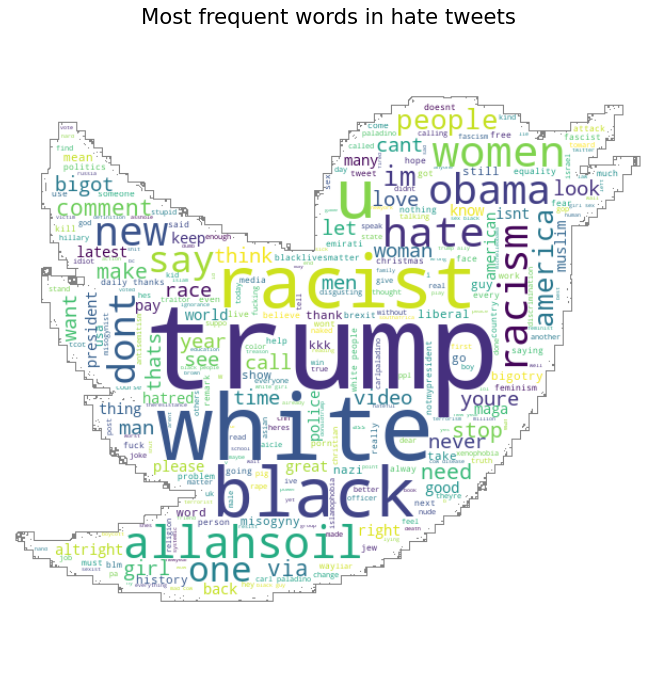

In [74]:
#plot word cloud for the Non HateSpeech
word_cloud(neg_tweets, 'Most frequent words in hate tweets')

#Feature Extraction and model training USING

# A. USING TFIDF VECTORIZER
**************************
Looking at feature extraction and model training using tfid vec

***************************

In [75]:
#perform Tfid vectorizer
#(This is uded to count the number of times each word appears in a document)
#and fit data on trigram language model
vect = TfidfVectorizer(lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,3)).fit(train_df['tweet'])
feature_names = vect.get_feature_names()
#print(feature_names.toarray())

##Testing Dataset
test_vect = TfidfVectorizer(lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,3)).fit(test_df['tweet'])
test_feature_names = test_vect.get_feature_names()

In [76]:
#assigning and splitting Data into training and testing
X = train_df['tweet']
Y = train_df['label']
X = vect.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#test Dataset
x_test_data = test_df['tweet']
x_test_data = vect.transform(x_test_data)


In [77]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))
print("Size of x_test_data: ", (x_test_data.shape))

Size of x_train: (22624, 316901)
Size of y_train: (22624,)
Size of x_test:  (5657, 316901)
Size of y_test:  (5657,)
Size of x_test_data:  (15684, 316901)


In [78]:
print(y_test)


30476    0
4685     0
15265    0
30495    0
7938     0
        ..
14356    0
1955     0
28309    0
31714    0
17896    0
Name: label, Length: 5657, dtype: int64


## Training Model using 


### 1. Logistic Regression Model

In [79]:
#Logistic Regression function.
def logreg_func(x_train,y_train,x_test,y_test):
  logreg = LogisticRegression()
  logreg.fit(x_train, y_train)

  logreg_predict = logreg.predict(x_test)
  logreg_acc = accuracy_score(logreg_predict, y_test)

  print("Test accuarcy: {:.2f}%".format(logreg_acc*100))

  print('\n printing cofusion metrix and classification report')
  print(confusion_matrix(y_test, logreg_predict))
  print("\n")
  print(classification_report(y_test, logreg_predict))
  
  print("\nConfusion metrix using display")
  style.use('classic')
  cm = confusion_matrix(y_test, logreg_predict, labels=logreg.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
  disp.plot()
  

Test accuarcy: 93.32%

 printing cofusion metrix and classification report
[[5276    1]
 [ 377    3]]


              precision    recall  f1-score   support

           0       0.93      1.00      0.97      5277
           1       0.75      0.01      0.02       380

    accuracy                           0.93      5657
   macro avg       0.84      0.50      0.49      5657
weighted avg       0.92      0.93      0.90      5657


Confusion metrix using display


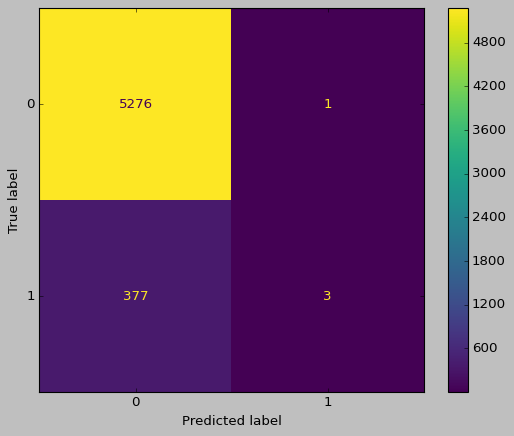

In [80]:
#Call the funtion to print predictions
logreg_func(x_train,y_train,x_test,y_test)



#### Hyper parameter Turning

In [81]:
#creating a funstion for Hyper parameter Turning
def hyper_turn_log_reg(x_train, y_train, x_test, y_test):
  param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
  grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
  grid.fit(x_train, y_train)

  print("Best Cross validation score: {:.2f}".format(grid.best_score_))
  print("Best parameters: ", grid.best_params_)
  print("\n\n\n\n") 

  y_pred = grid.predict(x_test)

  logreg_acc = accuracy_score(y_pred, y_test)
  print("Test accuracy: {:.2f}%".format(logreg_acc*100))

  print("\n\n Printing Confusion Metrix")
  print(confusion_matrix(y_test, y_pred))
  print("\n")
  print(classification_report(y_test, y_pred))

In [82]:
hyper_turn_log_reg(x_train, y_train, x_test, y_test)

Best Cross validation score: 0.95
Best parameters:  {'C': 100, 'solver': 'lbfgs'}





Test accuracy: 94.80%


 Printing Confusion Metrix
[[5272    5]
 [ 289   91]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5277
           1       0.95      0.24      0.38       380

    accuracy                           0.95      5657
   macro avg       0.95      0.62      0.68      5657
weighted avg       0.95      0.95      0.93      5657



### 2. Support Vector Machine


In [83]:
def SVM_func(x_train, y_train,x_test,y_test):
  SVCmodel = LinearSVC()
  SVCmodel.fit(x_train, y_train)
  
  svc_pred = SVCmodel.predict(x_test)
  svc_acc = accuracy_score(svc_pred, y_test)
  print('Printing accuracy\n****************************')
  print("test accuracy: {:.2f}%".format(svc_acc*100))

  print('\n\n\nPrint Confusion metrix*\n***************************')
  print(confusion_matrix(y_test, svc_pred))
  print('\n\n\nPrint Confusion Report*\n***************************')
  print(classification_report(y_test, svc_pred))

In [84]:
SVM_func(x_train, y_train,x_test,y_test)

Printing accuracy
****************************
test accuracy: 94.82%



Print Confusion metrix*
***************************
[[5274    3]
 [ 290   90]]



Print Confusion Report*
***************************
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5277
           1       0.97      0.24      0.38       380

    accuracy                           0.95      5657
   macro avg       0.96      0.62      0.68      5657
weighted avg       0.95      0.95      0.93      5657



#### Hyper parameter Turning

In [85]:
def hyper_turn_svm(x_train, y_train, x_test, y_test):
  SVCmodel = LinearSVC()
  
  grid = {'C':[0.01, 0.1, 1, 10]}
  grid = GridSearchCV(SVCmodel, grid)
  grid.fit(x_train, y_train)
  print("Best Cross validation score: {:.2f}".format(grid.best_score_))
  print("Best parameters: ", grid.best_params_)

  print("\n\n\n\n") 
  y_pred = grid.predict(x_test)

  svm_acc = accuracy_score(y_pred, y_test)
  print("Test accuracy: {:.2f}%".format(svm_acc*100))

  print("\n\n Printing Confusion Metrix")
  print(confusion_matrix(y_test, y_pred))
  print("\n")
  print(classification_report(y_test, y_pred))


In [86]:
hyper_turn_svm(x_train, y_train, x_test, y_test)

Best Cross validation score: 0.95
Best parameters:  {'C': 10}





Test accuracy: 95.16%


 Printing Confusion Metrix
[[5271    6]
 [ 268  112]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5277
           1       0.95      0.29      0.45       380

    accuracy                           0.95      5657
   macro avg       0.95      0.65      0.71      5657
weighted avg       0.95      0.95      0.94      5657



#B. BOW Vectorizer


In [87]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(train_df['tweet'])
x_train, x_test, y_train, y_test = train_test_split(bow, train_df['label'], random_state=42, test_size=0.2)

#fit and Transform test Data
test_bow = bow_vectorizer.fit_transform(test_df['tweet'])

### 1. Logistic Regression

Test accuarcy: 95.12%

 printing cofusion metrix and classification report
[[5247   30]
 [ 246  134]]


              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5277
           1       0.82      0.35      0.49       380

    accuracy                           0.95      5657
   macro avg       0.89      0.67      0.73      5657
weighted avg       0.95      0.95      0.94      5657


Confusion metrix using display


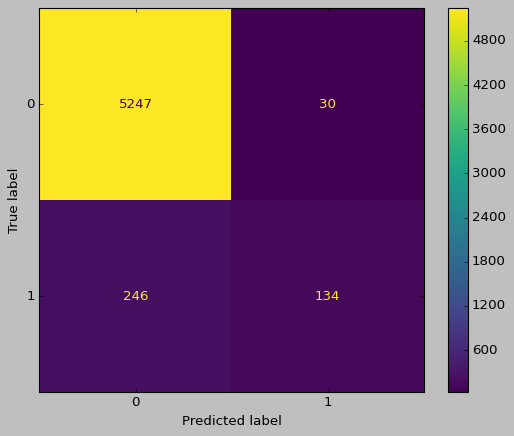

In [88]:
logreg_func(x_train,y_train,x_test,y_test)

#### Hyper parameter Turning

In [89]:
hyper_turn_log_reg(x_train, y_train, x_test, y_test)

Best Cross validation score: 0.95
Best parameters:  {'C': 10, 'solver': 'newton-cg'}





Test accuracy: 95.33%


 Printing Confusion Metrix
[[5222   55]
 [ 209  171]]


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5277
           1       0.76      0.45      0.56       380

    accuracy                           0.95      5657
   macro avg       0.86      0.72      0.77      5657
weighted avg       0.95      0.95      0.95      5657



### 2. Support Vector Machine


In [90]:
SVM_func(x_train, y_train,x_test,y_test)

Printing accuracy
****************************
test accuracy: 95.07%



Print Confusion metrix*
***************************
[[5197   80]
 [ 199  181]]



Print Confusion Report*
***************************
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5277
           1       0.69      0.48      0.56       380

    accuracy                           0.95      5657
   macro avg       0.83      0.73      0.77      5657
weighted avg       0.95      0.95      0.95      5657



#### Hyper parameter Turning

In [91]:
hyper_turn_svm(x_train, y_train, x_test, y_test)

Best Cross validation score: 0.95
Best parameters:  {'C': 0.1}





Test accuracy: 95.44%


 Printing Confusion Metrix
[[5251   26]
 [ 232  148]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5277
           1       0.85      0.39      0.53       380

    accuracy                           0.95      5657
   macro avg       0.90      0.69      0.76      5657
weighted avg       0.95      0.95      0.95      5657



## Checking whether model's performance can be improved using Cross Validation Score:

In [92]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, x_train, y_train, cv = 5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))

print('Average cross-validation score: {}'.format(scores.mean()))

Cross-validation scores:[0.95160221 0.95359116 0.95359116 0.95513812 0.95446508]
Average cross-validation score: 0.9536775454176863
